![header](images/header.jpg)

# Multiple Linear Regression Model
## King County, WA

**Authors**: [Jonathan Fetterolf](mailto:jonathan.fetterolf@gmail.com), [Ilan Haskel](mailto:ilanhaskel97@gmail.com), [Nate Kist](mailto:natekist@outlook.com)

# Overview

We analyzed a database of home sales in King County, WA to determine how different housing features impact sales price.  Regression analysis of these sales show potential opportunities for real estate flipping companies to earn more profit by buying in certain areas and adding features to a home that ultimately drive up the resale price more than the cost of the addition.  The analysis determined that buying properties in Skykomish, Algona, Federal Way, Enumclaw, and Auburn would likely result in more return on their investment and that adding a garage for under \\$38K or adding a patio for under \\$18K would likely result in higher profit. 

## Business Understanding and Business Problem

Our primary stakeholder is a company called Flipping Seattle, which flips houses in the King County area.  We are analyzing home sales to advise Flipping Seattle on:

 1. What geographic areas should they look in to generate the most return on investment? 
 2. What renovations or additions can be made to their properties to generate more profit upon sale?

Seattle Flippers, asked us to predict the prices of homes in the market so they can make
data driven decisions regarding potential houses to flip. Accurately modeling housing prices is incredibly important while flipping houses becuase the business is inherently risky and investors want to ensure a healthy return on investment. 

## Data Understanding

Data for this analysis is from the following database:

### King County Real Property Sales

The [King County Department of Assessments](https://info.kingcounty.gov/assessor/DataDownload/default.aspx) makes a dataset of recent home sales in the county available on their website . The initial dataset includes 30,155 home sale records representing sales between 6/10/21 and 6/9/22.  It has 25 columns of data. The column of primary interest in our modeling is price, as that will be used as the target in our model.  Other data of interest includes characteristics of the homes sold such as square footage, condition, and the existence of features such as a basement, patio or garage.

## Methods:  Data Preparation and Modeling

We created helpful functions that could be reused throughout our code in order to avoid duplication, including drop_outliers(), scale_numerical_cols(), mapping_addressStreet(), mapping_AddressCity(), mapping_is_good_city(), mapping_is_cheap_city(), mapping_hasX(), and mapping_hasView(). 

We removed unnecessary columns of data that were not used in our analysis, dropped outliers over/under the 1.5x IQR threshold on numerical predictors, and removed records with null values.  We also scaled our numerical predictors for ease of comparison.  

#### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera
from statsmodels.compat import lzip

#### Functions
Below are functions that are later used in the notebook.

In [2]:
def drop_outliers(df, col):
    q1 = df[col].quantile(.25)   
    q3 = df[col].quantile(.75)  
    iqr = q3 - q1 

    lower_lim = q1 - (1.5 * iqr)
    upper_lim = q3 + (1.5 * iqr)

    df = df.loc[ (df[col] >= lower_lim) & (df[col] <= upper_lim) ].reset_index(drop=True)
    return df

def scale_numerical_cols(df, cols_to_scale):
    df = df.copy()
    features = cols_to_scale
    autoscaler = StandardScaler()
    df[features] = autoscaler.fit_transform(df[features])
    return df

#### Importing Data

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


#### Drop Outliers 
We decided to drop outliers from all the numerical columns we ultimately use in our models, based on the accepted definition of outliers (rows falling outside of 1.5x the IQR on either side). We use our above function to do so.

In [5]:
df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'lat').reset_index(drop=True)
df = drop_outliers(df, 'long').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.644800e+04,2.644800e+04,26448.000000,26448.000000,26448.000000,2.644800e+04,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000,26448.000000
mean,4.573990e+09,9.351912e+05,3.368232,2.224686,1974.694722,1.533174e+04,1.489394,1694.948994,455.235632,315.399009,196.672754,1972.578910,84.517733,47.538115,-122.226111
std,2.872331e+09,4.291522e+05,0.944539,0.784825,757.739880,5.288984e+04,0.546934,712.103736,541.989620,268.232397,221.044850,31.396284,402.133419,0.150044,0.129056
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.000860,-122.526650
25%,2.144800e+09,6.250000e+05,3.000000,2.000000,1400.000000,4.900000e+03,1.000000,1160.000000,0.000000,0.000000,30.000000,1951.000000,0.000000,47.406360,-122.333720
50%,3.888100e+09,8.256500e+05,3.000000,2.500000,1870.000000,7.363000e+03,1.000000,1510.000000,0.000000,380.000000,130.000000,1974.000000,0.000000,47.550050,-122.257115
75%,7.298013e+09,1.190000e+06,4.000000,2.500000,2450.000000,1.013625e+04,2.000000,2110.000000,920.000000,500.000000,290.000000,1999.000000,0.000000,47.673410,-122.139277
max,9.904000e+09,2.230000e+06,11.000000,7.500000,4410.000000,3.067495e+06,4.000000,5500.000000,3560.000000,2840.000000,2880.000000,2022.000000,2022.000000,47.876700,-121.829060


#### Finding & Dropping Nulls
We pull out all of the null values existing in the dataframe as part of the cleaning process, so as to minimize errors later down the line.

In [6]:
df.isnull().sum().sum()

28

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
df.isnull().sum().sum()

0

#### Dropping Undesired Columns
We decide to drop columns with features that cannot be changed easily by our stakeholder, such as year renovated and view from the house.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26420 entries, 0 to 26419
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26420 non-null  int64  
 1   date           26420 non-null  object 
 2   price          26420 non-null  float64
 3   bedrooms       26420 non-null  int64  
 4   bathrooms      26420 non-null  float64
 5   sqft_living    26420 non-null  int64  
 6   sqft_lot       26420 non-null  int64  
 7   floors         26420 non-null  float64
 8   waterfront     26420 non-null  object 
 9   greenbelt      26420 non-null  object 
 10  nuisance       26420 non-null  object 
 11  view           26420 non-null  object 
 12  condition      26420 non-null  object 
 13  grade          26420 non-null  object 
 14  heat_source    26420 non-null  object 
 15  sewer_system   26420 non-null  object 
 16  sqft_above     26420 non-null  int64  
 17  sqft_basement  26420 non-null  int64  
 18  sqft_g

In [10]:
df = df.drop(['view', 
              'sqft_above',
              'sqft_basement', 
              'yr_renovated', 
              'id'
             ], axis=1)

#### Feature Engineering - ZIP Codes 
Extract only the 5 digit ZIP Code from each entry in the 'address' column, for use later as a possible feature.

In [11]:
df['zipcode'] = df.address.str[-20:-15]
df['zipcode'].value_counts()

98042    985
98038    853
98103    740
98117    731
98115    719
        ... 
98372      2
98050      1
98422      1
98296      1
98387      1
Name: zipcode, Length: 79, dtype: int64

### Modeling - Round one

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26420 entries, 0 to 26419
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26420 non-null  object 
 1   price         26420 non-null  float64
 2   bedrooms      26420 non-null  int64  
 3   bathrooms     26420 non-null  float64
 4   sqft_living   26420 non-null  int64  
 5   sqft_lot      26420 non-null  int64  
 6   floors        26420 non-null  float64
 7   waterfront    26420 non-null  object 
 8   greenbelt     26420 non-null  object 
 9   nuisance      26420 non-null  object 
 10  condition     26420 non-null  object 
 11  grade         26420 non-null  object 
 12  heat_source   26420 non-null  object 
 13  sewer_system  26420 non-null  object 
 14  sqft_garage   26420 non-null  int64  
 15  sqft_patio    26420 non-null  int64  
 16  yr_built      26420 non-null  int64  
 17  address       26420 non-null  object 
 18  lat           26420 non-nu

#### Feeature Engineering - Age When Sold
We created another variable for use in our model, found by subtracting the year the house was built from the year in which the house was sold.

In [13]:
df['date'].value_counts()
df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']

df['age_when_sold'] = df['date_year'] - df['yr_built']
df['age_when_sold'].value_counts()

 0      988
 1      509
 44     473
 54     467
 53     447
       ... 
 87      35
 88      33
 119     33
 120     32
-1       30
Name: age_when_sold, Length: 124, dtype: int64

In [14]:
df['yr_built'].value_counts()

2021    1129
1968     482
1967     451
1978     450
1977     450
        ... 
1901      36
1935      35
1934      34
1902      31
1933      29
Name: yr_built, Length: 123, dtype: int64

In [15]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,lat,long,date_year,age_when_sold
count,2.642000e+04,26420.000000,26420.000000,26420.000000,2.642000e+04,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000,26420.000000
mean,9.354395e+05,3.369531,2.225360,1975.344928,1.524770e+04,1.489421,315.607419,196.662983,1972.573051,47.538172,-122.226127,2021.354996,48.781945
std,4.291241e+05,0.943124,0.784123,757.302280,5.227460e+04,0.547000,268.206900,220.967477,31.388103,0.150008,0.128973,0.478521,31.406812
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,1900.000000,47.000860,-122.526650,2021.000000,-1.000000
25%,6.250000e+05,3.000000,2.000000,1400.000000,4.900000e+03,1.000000,0.000000,30.000000,1951.000000,47.406434,-122.333679,2021.000000,22.000000
50%,8.260000e+05,3.000000,2.500000,1870.000000,7.360000e+03,1.000000,380.000000,130.000000,1974.000000,47.550115,-122.257115,2021.000000,47.000000
75%,1.190470e+06,4.000000,2.500000,2450.000000,1.013200e+04,2.000000,500.000000,290.000000,1999.000000,47.673411,-122.139277,2022.000000,70.000000
max,2.230000e+06,11.000000,7.500000,4410.000000,3.067495e+06,4.000000,2840.000000,2880.000000,2022.000000,47.876700,-121.829060,2022.000000,122.000000


#### Checking Correlation

Finding the most correlated column to price.

In [16]:
abs(df.corr()['price']).sort_values()

sqft_lot         0.060780
age_when_sold    0.073991
yr_built         0.075396
date_year        0.089280
long             0.145425
floors           0.209825
sqft_garage      0.216967
sqft_patio       0.233824
bedrooms         0.299602
bathrooms        0.418828
lat              0.440139
sqft_living      0.547406
price            1.000000
Name: price, dtype: float64

We can see that square footage of living space appears to be the most correlated with price. The two have a moderate positive correlation of 0.54.

#### EDA Visualizations
**Heatmap**

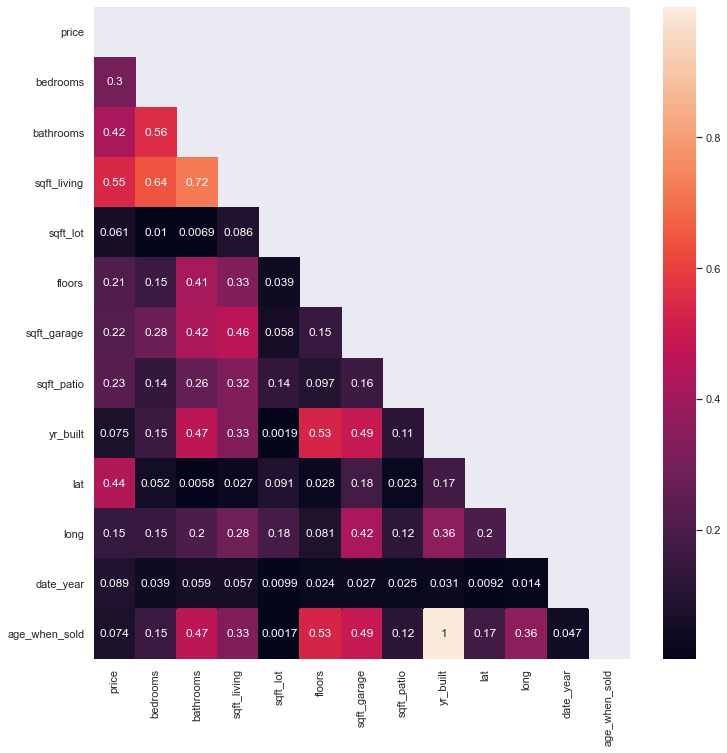

In [17]:
sns.set(rc={'figure.figsize':(12, 12)})

# Use the .heatmap function to depict the relationships visually!
mask  = np.triu(np.ones_like(df.corr()))
sns.heatmap(abs(df.corr()), annot=True, mask=mask);

Using the heatmap to analyze correlation between our variables also helps to get ahead of any multicollinearity problems we may have once our model is actually constructed. For example, we can see from the visualization that number of bathrooms and square-feet of livable space have a high positive correlation of 0.72.

**Log Scale Target**  -  ( Price )

Below we create a histogram of the distribution of our target (price). We can see a slight right-skew to our data, which we will try normalizing by log-scaling our target.

<AxesSubplot:xlabel='price', ylabel='Count'>

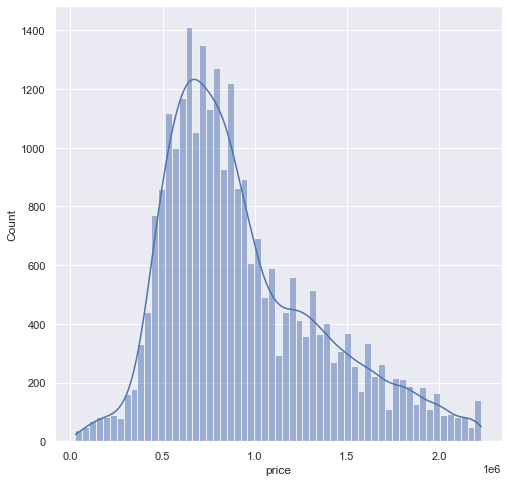

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df.price, kde=True)

As seen below, log-scaling our target actually overcompensates for the initial right-skew and adds a left-skew to our target's distribution. For the next chunk of our notebook, we experiment with using both our original target and its log-scaled version in our model to see how the difference affects model performance.

<AxesSubplot:xlabel='price', ylabel='Count'>

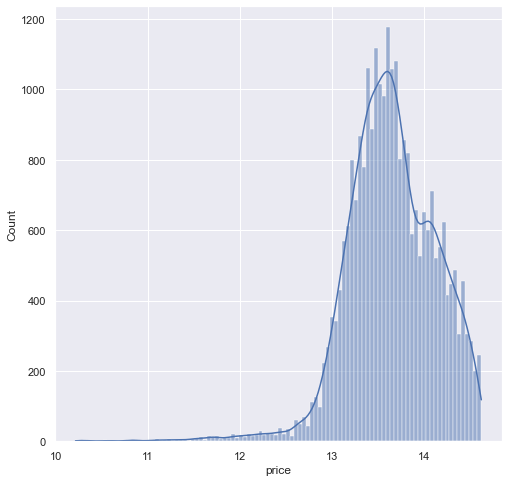

In [19]:
#logscaling target
fig, ax = plt.subplots(figsize=(8,8))
y2 = np.log(df.price)
sns.histplot(y2, kde=True)

#### Baseline OLS Model
Here we construct our first baseline model, taking only numerical variables as predictors. The predictors we used to estimate price were square-footage of livable space, square-footage of lot size, and square-footage of patio size.

In [20]:
x = sm.add_constant(df[['sqft_living', 'sqft_lot', 'sqft_patio']])
y = df['price']
model = sm.OLS(y, x).fit()
model.rsquared

0.3033787884100603

**Baseline Results**

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3835.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:31   Log-Likelihood:            -3.7537e+05
No. Observations:               26420   AIC:                         7.507e+05
Df Residuals:                   26416   BIC:                         7.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.212e+05   6158.583     52.150      0.000    3.09e+05    3.33e+05
sqft_living   298.3032      3.077     96.946      0.000     292.272     304.334
sqft_lot        0.0567      0.043      1.330      0.183      -0.027       0.140
sqft_patio    122.8036     10.605     11.580      0.000     102.017     143.590
==============================================================================
Omnibus:                     1260.728   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.723
Skew:                           0.524   Prob(JB):                         0.00
Kurtosis:                       3.518   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Analyzing our model's summary statistics, we can note that our R-squared score outperforms a baseline model, but there is still some work we can do to try and improve how accurately our predictors account for variance in our target. It is worth noting that some of our model's summary statistics, such as condition number, suggest that we violate some of the linear regression assumptions. For now we are simply trying to iterate to improve our R-squared score, though we address concerns with assumptions later in our notebook.

#### Log Scaled OLS Model

Now we try the same model using our log-scaled target to see how it performs.

In [22]:
x = sm.add_constant(df[['sqft_living', 'sqft_lot', 'sqft_patio']])
y2 = np.log(df['price'])
model = sm.OLS(y2, x).fit()
model.rsquared

0.2552250673702846

**Log Scaled Model Results**

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     3017.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:31   Log-Likelihood:                -14547.
No. Observations:               26420   AIC:                         2.910e+04
Df Residuals:                   26416   BIC:                         2.914e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.0027      0.007   1801.914      0.000      12.989      13.017
sqft_living     0.0003   3.61e-06     85.852      0.000       0.000       0.000
sqft_lot    -1.491e-08   4.99e-08     -0.299      0.765   -1.13e-07    8.29e-08
sqft_patio      0.0001   1.24e-05     10.947      0.000       0.000       0.000
==============================================================================
Omnibus:                     7865.705   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50024.140
Skew:                          -1.279   Prob(JB):                         0.00
Kurtosis:                       9.237   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As expected, looking at our new R-squared score, our model with our target log-scaled performs worse than without it. From this point forward, we use our unscaled target.

#### OLS Modifications

Next we try dropping some columns to address multicolinearity and see if we can get a better R-squared score. We also add our engineered column for the age of the house when it was sold to see if it helps our model.

In [24]:
x = sm.add_constant(df[['sqft_living', 'age_when_sold']])
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     5998.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:31   Log-Likelihood:            -3.7520e+05
No. Observations:               26420   AIC:                         7.504e+05
Df Residuals:                   26417   BIC:                         7.504e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.994e+05   8287.550     24.065      0.000    1.83e+05    2.16e+05
sqft_living     332.4032      3.062    108.565      0.000     326.402     338.404
age_when_sold  1627.4028     73.828     22.043      0.000    1482.696    1772.109
==============================================================================
Omnibus:                     1187.902   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1438.162
Skew:                           0.493   Prob(JB):                         0.00
Kurtosis:                       3.578   Cond. No.                     8.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As seen in the above model summary, our R-squared score increased by a small amount, suggesting this new model does a better job of predicting price than the last one. We can also see that our condition number dropped by an order of magnitude, suggesting that dropping some columns helped with multicollinearity issues. All this said, our R-squared score is still lower than we would like it and our condition number is still high enough to suggest multicollinearity. We continue iterating.

#### OLS Modifications - OneHotEncoding
Here we decide to start incorporating some categorical variables into our model, using One-Hot Encoding. Specifically, we dummy-out and try incorporating features for the number of bathrooms, number of bedrooms, condition, and heat source in a house. We also make sure to drop the first encoded feature from each of these categories, so as to help control for multicollinearity.

In [25]:
# One-Hot Encoding our categorical variables

#0:number of baths
#1:number of bedrooms
#2:condition
#3:heat source

ohe = OneHotEncoder(drop='first')
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source']
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                        columns=ohe.get_feature_names())
ohe_all
X_cat = pd.concat([x,ohe_all], axis=1)
X_cat.head(2)

,const,sqft_living,age_when_sold,x0_0.5,x0_1.0,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,...,x2_Fair,x2_Good,x2_Poor,x2_Very Good,x3_Electricity/Solar,x3_Gas,x3_Gas/Solar,x3_Oil,x3_Oil/Solar,x3_Other
0,1.0,1180,53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,2770,71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
# Creating our new model using one-hot encoded categorical features
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     349.6
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:32   Log-Likelihood:            -3.7475e+05
No. Observations:               26420   AIC:                         7.496e+05
Df Residuals:                   26381   BIC:                         7.499e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.719e+05    7.6e+04      3.579      0.000    1.23e+05    4.21e+05
sqft_living            315.6147      4.719     66.886      0.000     306.366     324.864
age_when_sold         2306.5240     91.213     25.287      0.000    2127.741    2485.307
x0_0.5                4.207e+05   1.88e+05      2.236      0.025    5.19e+04     7.9e+05
x0_1.0                2.039e+05   1.04e+05      1.957      0.050    -303.442    4.08e+05
x0_1.5                2.354e+05   1.04e+05      2.255      0.024    3.08e+04     4.4e+05
x0_2.0                2.843e+05   1.04e+05      2.729      0.006    8.01e+04    4.88e+05
x0_2.5                3.403e+05   1.04e+05      3.269      0.001    1.36e+05    5.44e+05
x0_3.0                3.575e+05   1.04e+05      3.430      0.001    1.53e+05    5.62e+05
x0_3.5                4.663e+05   1.04e+05      4.464      0.000    2.62e+05    6.71e+05
x0_4.0                4.548e+05   1.05e+05      4.312      0.000    2.48e+05    6.61e+05
x0_4.5                4.401e+05   1.08e+05      4.070      0.000    2.28e+05    6.52e+05
x0_5.0                3.697e+05   1.19e+05      3.104      0.002    1.36e+05    6.03e+05
x0_5.5                7.582e+04   1.36e+05      0.556      0.578   -1.91e+05    3.43e+05
x0_6.0                6.282e+05   1.45e+05      4.336      0.000    3.44e+05    9.12e+05
x0_6.5                8.094e+05   2.28e+05      3.548      0.000    3.62e+05    1.26e+06
x0_7.0                4.396e+05   2.28e+05      1.924      0.054   -8143.566    8.87e+05
x0_7.5                3.797e+05   2.76e+05      1.373      0.170   -1.62e+05    9.22e+05
x1_1                 -2.607e+05   8.58e+04     -3.038      0.002   -4.29e+05   -9.25e+04
x1_2                 -3.291e+05   8.39e+04     -3.921      0.000   -4.94e+05   -1.65e+05
x1_3                 -4.069e+05   8.39e+04     -4.848      0.000   -5.71e+05   -2.42e+05
x1_4                 -4.464e+05   8.41e+04     -5.306      0.000   -6.11e+05   -2.82e+05
x1_5                 -5.166e+05   8.45e+04     -6.112      0.000   -6.82e+05   -3.51e+05
x1_6                 -5.788e+05   8.63e+04     -6.705      0.000   -7.48e+05    -4.1e+05
x1_7                 -5.965e+05   9.63e+04     -6.192      0.000   -7.85e+05   -4.08e+05
x1_8                 -6.843e+05   1.07e+05     -6.411      0.000   -8.94e+05   -4.75e+05
x1_9                 -6.432e+05   1.38e+05     -4.661      0.000   -9.14e+05   -3.73e+05
x1_10                 -7.41e+05   4.14e+05     -1.791      0.073   -1.55e+06    6.99e+04
x1_11                -4.156e+05   3.61e+05     -1.153      0.249   -1.12e+06    2.91e+05
x2_Fair              -6.827e+04   2.45e+04     -2.787      0.005   -1.16e+05   -2.03e+04
x2_Good               7249.5065   5191.628      1.396      0.163   -2926.365    1.74e+04
x2_Poor              -1.674e+05    4.6e+04     -3.643    

This new model incorporating some categorical features has a slightly higher R-squared score than our previous iteration, but we see the condition number jump up two orders of magnitude, suggesting stronger problems with multicollinearity.

#### Scale Numerical Columns
Here we take a break from feature selection and engineering to Standard Scale our numeric variables. This is in order to make their coefficients easier to compare with one another.

In [27]:
df = scale_numerical_cols(df, ['sqft_living', 'age_when_sold', 'long', 'lat'])
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_garage,sqft_patio,yr_built,address,lat,long,zipcode,date_year,age_when_sold
0,5/24/2022,675000.0,4,1.0,-1.050254,7140,1.0,NO,NO,NO,...,PUBLIC,0,40,1969,"2102 Southeast 21st Court, Renton, Washington ...",-0.507960,0.276085,98055,2022,0.134306
1,12/13/2021,920000.0,5,2.5,1.049343,6703,1.0,NO,NO,YES,...,PUBLIC,0,240,1950,"11231 Greenwood Avenue North, Seattle, Washing...",1.155646,-1.006297,98133,2021,0.707441
2,9/29/2021,311000.0,6,2.0,1.194599,6156,1.0,NO,NO,NO,...,PUBLIC,0,0,1956,"8504 South 113th Street, Seattle, Washington 9...",-0.240836,0.007187,98178,2021,0.516396
3,12/14/2021,775000.0,3,3.0,0.243837,1400,2.0,NO,NO,NO,...,PUBLIC,200,270,2010,"4079 Letitia Avenue South, Seattle, Washington...",0.186248,-0.496803,98118,2021,-1.203008
4,8/24/2021,592500.0,2,2.0,-1.129484,758,2.0,NO,NO,YES,...,PUBLIC,550,30,2012,"2193 Northwest Talus Drive, Issaquah, Washingt...",-0.038010,1.195983,98027,2021,-1.266690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,11/30/2021,1555000.0,5,2.0,-0.086288,4000,1.5,NO,NO,NO,...,PUBLIC,0,210,1921,"4673 Eastern Avenue North, Seattle, Washington...",0.843758,-0.800747,98103,2021,1.630825
26416,6/16/2021,1313000.0,3,2.0,0.058967,5800,2.0,NO,NO,NO,...,PUBLIC,0,520,2011,"4131 44th Avenue Southwest, Seattle, Washingto...",0.182915,-1.259068,98116,2021,-1.234849
26417,5/27/2022,800000.0,3,2.0,-0.469234,3600,1.0,NO,NO,YES,...,PUBLIC,240,110,1995,"910 Martin Luther King Jr Way, Seattle, Washin...",0.481471,-0.540611,98122,2022,-0.693555
26418,2/24/2022,775000.0,3,2.5,0.785243,2889,2.0,NO,NO,NO,...,PUBLIC,480,100,2006,"17127 114th Avenue Southeast, Renton, Washingt...",-0.591190,0.287250,98055,2022,-1.043804


In [28]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source']

ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     349.6
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:32   Log-Likelihood:            -3.7475e+05
No. Observations:               26420   AIC:                         7.496e+05
Df Residuals:                   26381   BIC:                         7.499e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.719e+05    7.6e+04      3.579      0.000    1.23e+05    4.21e+05
sqft_living            315.6147      4.719     66.886      0.000     306.366     324.864
age_when_sold         2306.5240     91.213     25.287      0.000    2127.741    2485.307
x0_0.5                4.207e+05   1.88e+05      2.236      0.025    5.19e+04     7.9e+05
x0_1.0                2.039e+05   1.04e+05      1.957      0.050    -303.442    4.08e+05
x0_1.5                2.354e+05   1.04e+05      2.255      0.024    3.08e+04     4.4e+05
x0_2.0                2.843e+05   1.04e+05      2.729      0.006    8.01e+04    4.88e+05
x0_2.5                3.403e+05   1.04e+05      3.269      0.001    1.36e+05    5.44e+05
x0_3.0                3.575e+05   1.04e+05      3.430      0.001    1.53e+05    5.62e+05
x0_3.5                4.663e+05   1.04e+05      4.464      0.000    2.62e+05    6.71e+05
x0_4.0                4.548e+05   1.05e+05      4.312      0.000    2.48e+05    6.61e+05
x0_4.5                4.401e+05   1.08e+05      4.070      0.000    2.28e+05    6.52e+05
x0_5.0                3.697e+05   1.19e+05      3.104      0.002    1.36e+05    6.03e+05
x0_5.5                7.582e+04   1.36e+05      0.556      0.578   -1.91e+05    3.43e+05
x0_6.0                6.282e+05   1.45e+05      4.336      0.000    3.44e+05    9.12e+05
x0_6.5                8.094e+05   2.28e+05      3.548      0.000    3.62e+05    1.26e+06
x0_7.0                4.396e+05   2.28e+05      1.924      0.054   -8143.566    8.87e+05
x0_7.5                3.797e+05   2.76e+05      1.373      0.170   -1.62e+05    9.22e+05
x1_1                 -2.607e+05   8.58e+04     -3.038      0.002   -4.29e+05   -9.25e+04
x1_2                 -3.291e+05   8.39e+04     -3.921      0.000   -4.94e+05   -1.65e+05
x1_3                 -4.069e+05   8.39e+04     -4.848      0.000   -5.71e+05   -2.42e+05
x1_4                 -4.464e+05   8.41e+04     -5.306      0.000   -6.11e+05   -2.82e+05
x1_5                 -5.166e+05   8.45e+04     -6.112      0.000   -6.82e+05   -3.51e+05
x1_6                 -5.788e+05   8.63e+04     -6.705      0.000   -7.48e+05    -4.1e+05
x1_7                 -5.965e+05   9.63e+04     -6.192      0.000   -7.85e+05   -4.08e+05
x1_8                 -6.843e+05   1.07e+05     -6.411      0.000   -8.94e+05   -4.75e+05
x1_9                 -6.432e+05   1.38e+05     -4.661      0.000   -9.14e+05   -3.73e+05
x1_10                 -7.41e+05   4.14e+05     -1.791      0.073   -1.55e+06    6.99e+04
x1_11                -4.156e+05   3.61e+05     -1.153      0.249   -1.12e+06    2.91e+05
x2_Fair              -6.827e+04   2.45e+04     -2.787      0.005   -1.16e+05   -2.03e+04
x2_Good               7249.5065   5191.628      1.396      0.163   -2926.365    1.74e+04
x2_Poor              -1.674e+05    4.6e+04     -3.643    

As expected, standard scaling did not change any of our model's performance statistics, as it is only designed to make relative strength of feature coefficients more easily interpretable.

#### OneHotEncoding
**Testing of Additional Categorical Features**

We continue adding features to our model, with the hopes of improving our R-squared score. We decide to incorporate more categorical variables, such as amount of floors, proximity to a waterfront, zipcode, and grade. Before applying them to our model, we first have to one-hot encode these as well.

In [29]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'condition', 
            'heat_source',
            'waterfront', 
            'floors', 
            'zipcode',
            'grade']

ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     455.1
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:33   Log-Likelihood:            -3.6436e+05
No. Observations:               26420   AIC:                         7.290e+05
Df Residuals:                   26286   BIC:                         7.301e+05
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.353e+05   5.48e+04      7.943      0.000    3.28e+05    5.43e+05
sqft_living            201.8509      3.806     53.040      0.000     194.392     209.310
age_when_sold          963.0366     83.056     11.595      0.000     800.242    1125.831
x0_0.5                4.721e+05   1.28e+05      3.693      0.000    2.22e+05    7.23e+05
x0_1.0                3.422e+05   7.08e+04      4.834      0.000    2.03e+05    4.81e+05
x0_1.5                3.207e+05   7.09e+04      4.522      0.000    1.82e+05     4.6e+05
x0_2.0                 3.36e+05   7.07e+04      4.752      0.000    1.97e+05    4.75e+05
x0_2.5                 3.56e+05   7.07e+04      5.035      0.000    2.17e+05    4.95e+05
x0_3.0                3.681e+05   7.08e+04      5.200      0.000    2.29e+05    5.07e+05
x0_3.5                3.816e+05    7.1e+04      5.377      0.000    2.42e+05    5.21e+05
x0_4.0                3.943e+05   7.16e+04      5.505      0.000    2.54e+05    5.35e+05
x0_4.5                4.168e+05   7.34e+04      5.675      0.000    2.73e+05    5.61e+05
x0_5.0                4.469e+05   8.08e+04      5.530      0.000    2.88e+05    6.05e+05
x0_5.5                1.167e+05   9.27e+04      1.260      0.208   -6.49e+04    2.98e+05
x0_6.0                5.882e+05   9.82e+04      5.991      0.000    3.96e+05    7.81e+05
x0_6.5                6.124e+05   1.55e+05      3.959      0.000    3.09e+05    9.16e+05
x0_7.0                4.915e+05   1.55e+05      3.177      0.001    1.88e+05    7.95e+05
x0_7.5                 5.45e+05   1.87e+05      2.913      0.004    1.78e+05    9.12e+05
x1_1                 -3.176e+05   5.83e+04     -5.444      0.000   -4.32e+05   -2.03e+05
x1_2                 -3.841e+05   5.71e+04     -6.730      0.000   -4.96e+05   -2.72e+05
x1_3                  -3.57e+05   5.71e+04     -6.253      0.000   -4.69e+05   -2.45e+05
x1_4                 -3.507e+05   5.72e+04     -6.127      0.000   -4.63e+05   -2.39e+05
x1_5                 -3.805e+05   5.75e+04     -6.615      0.000   -4.93e+05   -2.68e+05
x1_6                 -3.988e+05   5.87e+04     -6.790      0.000   -5.14e+05   -2.84e+05
x1_7                 -4.124e+05   6.55e+04     -6.294      0.000   -5.41e+05   -2.84e+05
x1_8                 -4.789e+05   7.26e+04     -6.597      0.000   -6.21e+05   -3.37e+05
x1_9                 -3.975e+05   9.37e+04     -4.243      0.000   -5.81e+05   -2.14e+05
x1_10                -8.344e+05    2.8e+05     -2.978      0.003   -1.38e+06   -2.85e+05
x1_11                -4.057e+05   2.44e+05     -1.661      0.097   -8.85e+05     7.3e+04
x2_Fair              -6.517e+04   1.67e+04     -3.912      0.000   -9.78e+04   -3.25e+04
x2_Good               5.111e+04   3650.232     14.001      0.000     4.4e+04    5.83e+04
x2_Poor              -1.087e+05   3.21e+04     -3.390    

It is at this point that we see our R-squared score make a huge jump: our model goes from accounting for only 30% of the variance in our target, to just under 70%. We can conclude that the addition of our new categorical variables is responsible for this improvement.

#### Ordinal Encoding
**Grade and Condition**

It is at this point that we realize that grade, one of the categorical variables incorporated in our current model, should not have been one-hot encoded. Instead, as an ordinal categorical variable, we need to use ordinal encoding to maintain the natural rank order in grade values.

In [30]:
df.grade.value_counts()

7 Average        11286
8 Good            8429
9 Better          2807
6 Low Average     2765
10 Very Good       629
5 Fair             373
11 Excellent        73
4 Low               43
3 Poor               8
12 Luxury            6
2 Substandard        1
Name: grade, dtype: int64

In [31]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))
grades_encoded

,0
0,5.0
1,5.0
2,5.0
3,7.0
4,5.0
...,...
26415,6.0
26416,5.0
26417,5.0
26418,6.0


Similarly, condition is a categorical feature being used in our model that should have been ordinally encoded as well. We proceed with re-encoding condition.

In [32]:
df.condition.value_counts()

Average      15675
Good          7472
Very Good     3003
Fair           211
Poor            59
Name: condition, dtype: int64

In [33]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded.head()

,0
0,3.0
1,2.0
2,2.0
3,2.0
4,2.0


In [34]:
# Creating a new dataframe with just our ordinally-encoded features, 
# to be later concatenated to our other predictor variables before model incorporation
ordinal_df = pd.concat([grades_encoded, cond_encoded], axis=1)
ordinal_df.columns = ['grade', 'condition']

In [35]:
ordinal_df

,grade,condition
0,5.0,3.0
1,5.0,2.0
2,5.0,2.0
3,7.0,2.0
4,5.0,2.0
...,...,...
26415,6.0,3.0
26416,5.0,2.0
26417,5.0,2.0
26418,6.0,2.0


#### Dropping condition and grade, and then adding their encoded columns

In [36]:
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'heat_source', 
            'waterfront',
            'floors', 
            'zipcode']
ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,ordinal_df], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     488.5
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:34   Log-Likelihood:            -3.6458e+05
No. Observations:               26420   AIC:                         7.294e+05
Df Residuals:                   26298   BIC:                         7.304e+05
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.702e+05   5.42e+04     -8.675      0.000   -5.76e+05   -3.64e+05
sqft_living            209.9231      3.815     55.020      0.000     202.445     217.401
age_when_sold         1091.6021     82.432     13.242      0.000     930.030    1253.174
x0_0.5                6.013e+05   1.29e+05      4.677      0.000    3.49e+05    8.53e+05
x0_1.0                4.073e+05   7.12e+04      5.719      0.000    2.68e+05    5.47e+05
x0_1.5                3.621e+05   7.14e+04      5.072      0.000    2.22e+05    5.02e+05
x0_2.0                3.771e+05   7.12e+04      5.297      0.000    2.38e+05    5.17e+05
x0_2.5                3.969e+05   7.12e+04      5.576      0.000    2.57e+05    5.36e+05
x0_3.0                4.089e+05   7.12e+04      5.739      0.000    2.69e+05    5.49e+05
x0_3.5                4.335e+05   7.14e+04      6.070      0.000    2.94e+05    5.74e+05
x0_4.0                4.436e+05   7.21e+04      6.154      0.000    3.02e+05    5.85e+05
x0_4.5                4.734e+05   7.39e+04      6.404      0.000    3.29e+05    6.18e+05
x0_5.0                5.021e+05   8.14e+04      6.171      0.000    3.43e+05    6.62e+05
x0_5.5                1.725e+05   9.33e+04      1.849      0.064   -1.04e+04    3.55e+05
x0_6.0                6.324e+05   9.89e+04      6.393      0.000    4.38e+05    8.26e+05
x0_6.5                6.617e+05   1.56e+05      4.245      0.000    3.56e+05    9.67e+05
x0_7.0                5.447e+05   1.56e+05      3.494      0.000    2.39e+05     8.5e+05
x0_7.5                5.714e+05   1.89e+05      3.030      0.002    2.02e+05    9.41e+05
x1_1                 -3.139e+05   5.85e+04     -5.368      0.000   -4.28e+05   -1.99e+05
x1_2                   -4.4e+05   5.72e+04     -7.693      0.000   -5.52e+05   -3.28e+05
x1_3                 -4.256e+05   5.72e+04     -7.441      0.000   -5.38e+05   -3.13e+05
x1_4                 -4.194e+05   5.73e+04     -7.315      0.000   -5.32e+05   -3.07e+05
x1_5                  -4.53e+05   5.76e+04     -7.863      0.000   -5.66e+05    -3.4e+05
x1_6                 -4.786e+05   5.88e+04     -8.134      0.000   -5.94e+05   -3.63e+05
x1_7                 -4.978e+05   6.57e+04     -7.579      0.000   -6.27e+05   -3.69e+05
x1_8                 -5.672e+05   7.29e+04     -7.785      0.000    -7.1e+05   -4.24e+05
x1_9                 -4.863e+05   9.42e+04     -5.162      0.000   -6.71e+05   -3.02e+05
x1_10                -8.777e+05   2.82e+05     -3.108      0.002   -1.43e+06   -3.24e+05
x1_11                -4.902e+05   2.46e+05     -1.991      0.046   -9.73e+05   -7722.808
x2_Electricity/Solar -6.847e+04   3.35e+04     -2.045      0.041   -1.34e+05   -2858.253
x2_Gas                9396.8046   3972.663      2.365      0.018    1610.170    1.72e+04
x2_Gas/Solar           1.24e+05   2.82e+04      4.391    

This correction had less of an impact on our model than initially anticipated, but it did change our R-squared score and some of our assumption test statistics a small amount.

#### Dropping Statistically Insignificant Values

Analyzing the p-values corresponding with our model predictors, we notice that some of them are above an alpha of 0.05, suggesting that the perceived relationships these features have with our target are not statistically significant. We proceed by dropping these specific predictors from our model and recreating it.

In [37]:
# Dropping insignificant values (<0.05)
ohe_all_sig = ohe_all.drop(['x2_Gas/Solar',
                           'x2_Oil',
                           'x2_Oil/Solar',
                           'x4_1.5',
                           'x4_2.0',
                           'x4_2.5',
                           'x4_3.5',
                           'x4_4.0',
                           'x5_98003',
                           'x5_98030',
                           'x5_98031',
                            'x5_98032',
                            'x5_98047',
                            'x5_98092',
                            'x5_98148',
                            'x5_98296',
                            'x5_98354',
                            'x5_98387'], axis=1)

In [38]:
# model with dropped insignificant values
ohe_cols = ['bathrooms', 
            'bedrooms', 
            'heat_source', 
            'waterfront',
            'floors', 
            'zipcode']
ohe = OneHotEncoder(drop='first')
    
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all_sig,ordinal_df], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     572.4
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:35   Log-Likelihood:            -3.6461e+05
No. Observations:               26420   AIC:                         7.294e+05
Df Residuals:                   26316   BIC:                         7.303e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.656e+05   5.35e+04     -8.710      0.000    -5.7e+05   -3.61e+05
sqft_living            210.6732      3.784     55.670      0.000     203.256     218.091
age_when_sold         1034.3422     75.002     13.791      0.000     887.334    1181.351
x0_0.5                 6.04e+05   1.29e+05      4.696      0.000    3.52e+05    8.56e+05
x0_1.0                4.066e+05   7.12e+04      5.708      0.000    2.67e+05    5.46e+05
x0_1.5                3.627e+05   7.14e+04      5.081      0.000    2.23e+05    5.03e+05
x0_2.0                3.771e+05   7.12e+04      5.298      0.000    2.38e+05    5.17e+05
x0_2.5                4.013e+05   7.12e+04      5.639      0.000    2.62e+05    5.41e+05
x0_3.0                4.106e+05   7.12e+04      5.764      0.000    2.71e+05     5.5e+05
x0_3.5                4.389e+05   7.14e+04      6.148      0.000    2.99e+05    5.79e+05
x0_4.0                4.483e+05   7.21e+04      6.221      0.000    3.07e+05     5.9e+05
x0_4.5                4.772e+05   7.39e+04      6.457      0.000    3.32e+05    6.22e+05
x0_5.0                5.044e+05   8.14e+04      6.199      0.000    3.45e+05    6.64e+05
x0_5.5                 1.74e+05   9.32e+04      1.867      0.062   -8672.165    3.57e+05
x0_6.0                6.354e+05   9.89e+04      6.426      0.000    4.42e+05    8.29e+05
x0_6.5                6.747e+05   1.56e+05      4.329      0.000    3.69e+05     9.8e+05
x0_7.0                5.453e+05   1.56e+05      3.496      0.000     2.4e+05    8.51e+05
x0_7.5                 5.76e+05   1.89e+05      3.053      0.002    2.06e+05    9.46e+05
x1_1                 -3.118e+05   5.85e+04     -5.329      0.000   -4.27e+05   -1.97e+05
x1_2                 -4.397e+05   5.72e+04     -7.684      0.000   -5.52e+05   -3.28e+05
x1_3                 -4.256e+05   5.72e+04     -7.437      0.000   -5.38e+05   -3.13e+05
x1_4                  -4.19e+05   5.74e+04     -7.305      0.000   -5.31e+05   -3.07e+05
x1_5                 -4.525e+05   5.76e+04     -7.850      0.000   -5.65e+05   -3.39e+05
x1_6                 -4.772e+05   5.89e+04     -8.106      0.000   -5.93e+05   -3.62e+05
x1_7                 -4.951e+05   6.57e+04     -7.535      0.000   -6.24e+05   -3.66e+05
x1_8                 -5.684e+05   7.29e+04     -7.800      0.000   -7.11e+05   -4.26e+05
x1_9                 -4.799e+05   9.42e+04     -5.095      0.000   -6.65e+05   -2.95e+05
x1_10                -8.706e+05   2.83e+05     -3.080      0.002   -1.42e+06   -3.17e+05
x1_11                -4.901e+05   2.46e+05     -1.990      0.047   -9.73e+05   -7310.933
x2_Electricity/Solar -6.583e+04   3.34e+04     -1.968      0.049   -1.31e+05    -269.516
x2_Gas                1.087e+04   3501.101      3.106      0.002    4011.459    1.77e+04
x2_Other              1.708e+05   5.82e+04      2.933    

Ultimately, we find that dropping our insignificant features did not affect model performance very much, nor did it improve our summary statistics pertaining to assumption problems.

### Evaluation / Results - Round one

#### Checking Model Assumptions

#### Linearity
Here we decide to take a deeper dive into seeing how our model stacks up against the assumptions of linear regression. The first assumption we check is linearity. For the results of a linear regression to be significant, the relationship between its target and predictors must be linear. We check this by constructing a scatter plot of our residuals plotted against our model predictions.

In [39]:
x.head()

,const,sqft_living,age_when_sold
0,1.0,1180,53
1,1.0,2770,71
2,1.0,2880,65
3,1.0,2160,11
4,1.0,1120,9


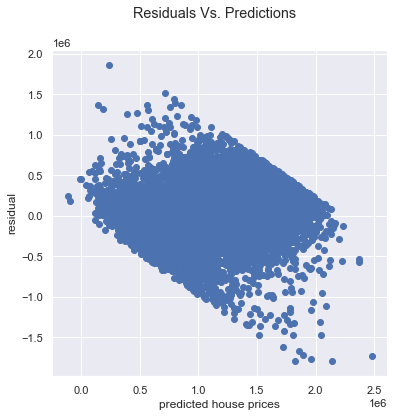

In [40]:
# plotting residuals vs predictions
model_preds = scaled_oheall_model.predict(X_cat)
resids = y - model_preds

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(model_preds, resids)

ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


From our plot, we can gather that the relationship between our target and our predictors is linear.

#### Independence
Next we check for independence of errors. We do this by plotting our residuals and target values against each other and looking for patterns.

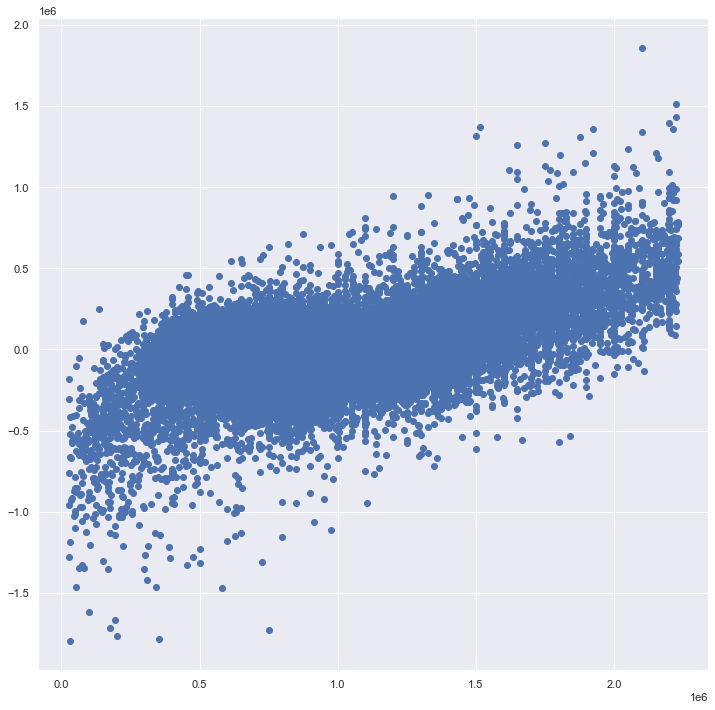

In [41]:
# plotting residuals and target value against each other
fig, ax = plt.subplots()

ax.scatter(y, resids);

The upwards trend in this plot suggests a very slight positive correlation in our errors.  
We can confirm by looking at the Durbin-Watson test statistic from our model.

In [42]:
durbin_watson(scaled_oheall_model.resid)

1.9740273780962416

This confirms the qualitative conclusion we drew from our scatter plot.  
Since the test statistic is below 2.0, we know there to be a very slight positive correlation in our errors.  
However, since our test statistic is so close to 2.0, we can confidently say that autocorrelation is not a problem for our regression model.

#### Normality

Next we check for noramlity. Our errors will ideally follow a normal distribution. We first check this by making a histogram of our residuals.

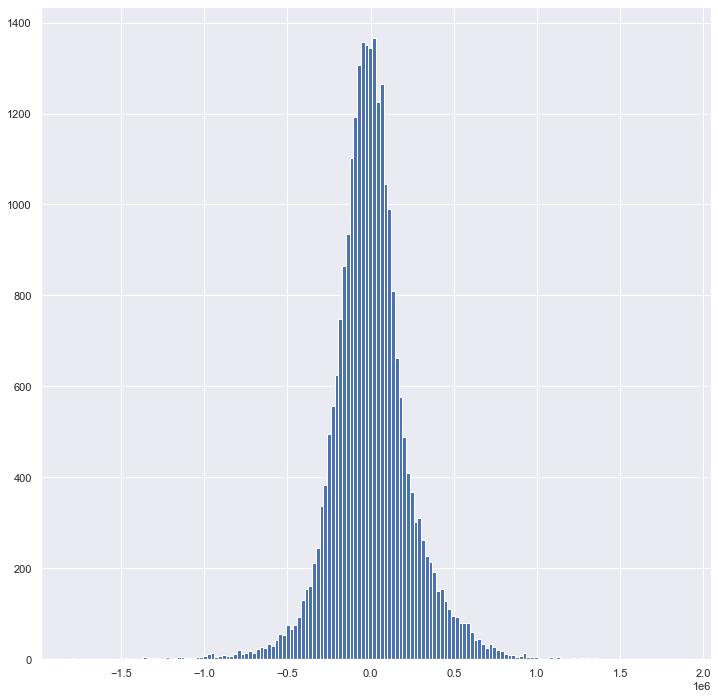

In [43]:
# Making a histogram out of our residuals
resids.hist(bins=int(np.sqrt(len(resids))));

Upon first glance at our histogram of residuals, our errors appear to be normally distributed.

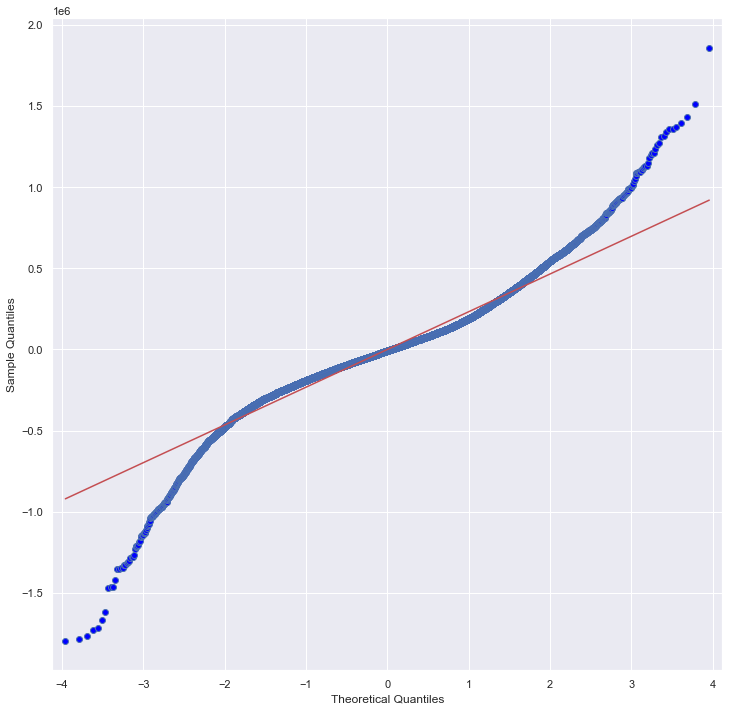

In [44]:
# Making a qqplot out of our residuals to further investigate
sm.qqplot(resids, line='r');

With normally distributed errors, our plot should follow the diagonal line closely.  
Instead, we see some fairly significant divergences at the extremes. This suggests that our errors may not follow a normal distribution.

In [45]:
# For more quantitative assessment of error distribution, we turn to the Jarque-Bera test:
jarque_bera(resids)

Jarque_beraResult(statistic=18351.139570174026, pvalue=0.0)

Based on the large magnitude of our test statistic and a P-value smaller than an alpha of 0.05, we must reject the null hypothesis that our errors are normally distributed.

Given more time, we could make individual histograms for each of our variables to see their distribution, as a non-normal distribution of errors is often caused by a non-normal distribution of variables. If we were to identify specific variables with non-normal distributions, we could try to transform the offending variables in some way to compensate. Another option would be to engineer new features based on our variables using Polynomial Features, in hopes of creating features with more normal distributions that still have a significant correlation with our target.

#### Homoscedasticity
Next we check for homoscedasticity. Our errors should have the same variance.

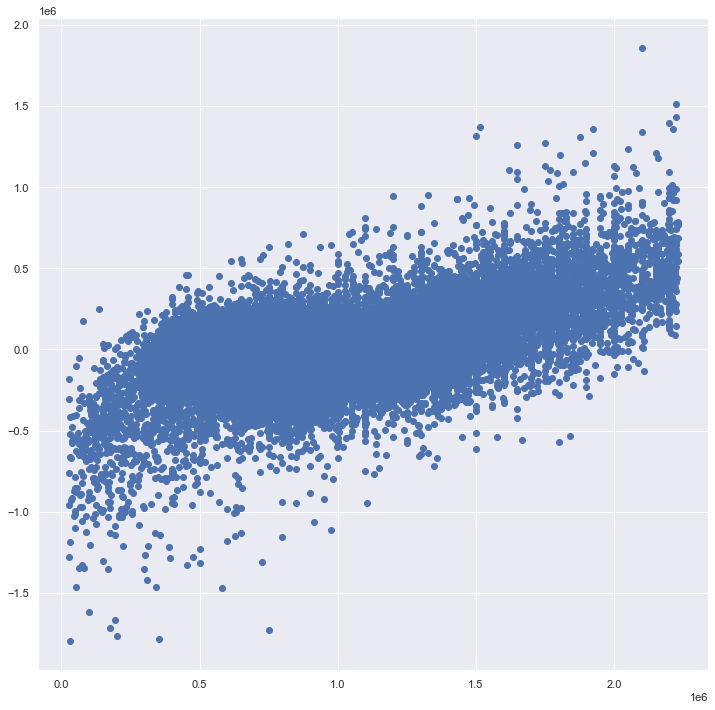

In [46]:
# We reproduce the plot from above, when we checked for independence of errors:

fig, ax = plt.subplots()

ax.scatter(y, resids);

At first glance, our errors appear to have similar variances. This is to say, the spread of our errors does not appear to vary much as our target increases. If anything, the spread may constrain slightly as our target increases, denoted by the larger presence of outliers around the smallest values of our target.

In [47]:
# For a more quantitative assessment of homoscedasticity, we employ the Goldfeld-Quant test:
sm.stats.diagnostic.het_goldfeldquandt(y,X_cat,drop=0.2)
# We chose to remove 20% of our total observations for the test, a common-practice proportion
# according to multiple online resources that were consulted.

(1.0218023963413203, 0.14345733771876557, 'increasing')

The Goldfeld-Quant test has a null hypothesis that homoscedasticity is present in our errors. Since the p-value for our test is greater than an alpha of 0.05, we fail to reject the null hypothesis and cannot gather that heteroscedasticity is a problem with our model.

In [48]:
# Turning to the Breusch-Pagan test for a second opinion on whether our data is homoscedastic:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
bp_test_result = sm.stats.diagnostic.het_breuschpagan(scaled_oheall_model.resid, scaled_oheall_model.model.exog)
lzip(names, bp_test_result)

[('Lagrange multiplier statistic', 1974.4663711504156),
 ('p-value', 0.0),
 ('f-value', 20.63634939207755),
 ('f p-value', 0.0)]

Since our p-value is smaller than our alpha of 0.05 and our test statistic is quite high for our number of predictors, we must reject the null hypothesis and conclude that there is some evidence to suggest that our errors are heteroscedastic. 

A possible solution would be to transform our target variable in some way, such as log-scaling. However, as discussed earlier, log-scaling our target variable makes its distribution less normal than it is currently.

Given more time, we could test other transformations of our target to try and account for the skew in its distribution.

#### Independence of Predictors (No Multicollinearity)
Finally, we check for independence of predictors.

In [49]:
# Pulling out our model's condition number to tease out multicollinearity:
scaled_oheall_model.condition_number

490577.23677665746

Our current model's condition number is well above the generally accepted 'danger zone' of approximately 1000. We can gather from this that our predictors have a significant amount of correlation with one another, implying the presence of multicollinearity. Likely, this has to do with the large number of predictors used in our model. A logical improvement given more time is to try and cut down the number of predictor variables used and optimizing our model's R-squared score with its condition number.

### Modeling - Round two

**Adding new mapper functions to parse out some df columns**

In [50]:
# New Mapper functions for changing df values
def mapping_addressStreet(row):
    row = row.split(",")[0]
    row = row.split(" ")
    row = " ".join(row[1:])
    return row 

def mapping_addressCity(row):
    row = row.split(",")[-3].strip()
    return row 

def mapping_is_good_city(row):
    row = row in good_cities
    return row

def mapping_is_cheap_city(row):
    row = row in cheap_cities
    return row

def mapping_hasX(row):
    if row == 0:
        row = "No"
    else:
        row = "Yes"
    return row

def mapping_hasView(row):
    if row == "NONE" or row == 'Average':
        row = "No"
    else:
        row = "Yes"
    return row

#### New baseline model
**Trying a new baseline model to get better model statistics.**
- only comparing sqft_foot living vs target of price

In [51]:
# lets start from new baseline and play around with some new ideas on features 

df = pd.read_csv('data/kc_house_data.csv')

df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df = df.dropna().reset_index(drop=True)


df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']
df['age_when_sold'] = df['date_year'] - df['yr_built']
df = drop_outliers(df, 'age_when_sold').reset_index(drop=True)

# Continuous numbers
#df['sqft_living']
df['sqft_lot_less_living'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

# Nominal categories
df['zipcode'] = df.address.str[-20:-15]
df['has_garage'] = df['sqft_garage'].map(mapping_hasX)
df['has_patio'] = df['sqft_patio'].map(mapping_hasX)
df['has_basement'] = df['sqft_basement'].map(mapping_hasX)
df['was_renovated'] = df['yr_renovated'].map(mapping_hasX)
df['has_view'] = df['view'].map(mapping_hasView)

df['waterfront']
df['street'] = df['address'].map(mapping_addressStreet)
df['city'] = df['address'].map(mapping_addressCity)
good_cities = ['Algona', 'Auburn', 'Beaux Arts Village', 'Bellevue', 
 'Black Diamond', 'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 
 'Covington', 'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 
 'Hunts Point', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland', 
 'Lake Forest Park', 'Maple Valley', 'Medina', 'Mercer Island', 'Milton', 
 'Newcastle', 'Normandy Park', 'North Bend', 'Pacific', 'Redmond', 
 'Renton', 'Sammamish', 'SeaTac', 'Seattle', 'Shoreline', 'Skykomish', 
 'Snoqualmie', 'Tukwila', 'Woodinville', 'Yarrow Point']
df['good_city'] = df['city'].map(mapping_is_good_city)
df = df.loc[df['good_city'] == True].reset_index(drop=True)
# Ordinal categories
df['grade']

# Scale the continous number features
df = scale_numerical_cols(df, ['sqft_living', 'age_when_sold', 'sqft_lot_less_living'])

# Baseline
x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.2959834855377248


Omnibus:,1184.396,Durbin-Watson:,2.008
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1381.055
Skew:,0.513,Prob(JB):,1.28e-300
Kurtosis:,3.446,Cond. No.,1.00


**Add New Feature - 'sqft_lot_less_living'**

In [52]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.2962058300002882


Omnibus:,1174.291,Durbin-Watson:,2.008
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1366.347
Skew:,0.511,Prob(JB):,2.00e-297
Kurtosis:,3.439,Cond. No.,1.08


**sqft_lot_less_living** helps out jarque bera a tiny amount

Add in 'age_when_sold' Feature

In [53]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living', 'age_when_sold']])    
y = df['price']
model = sm.OLS(y, x).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]


r sqr: 0.30950338776872865


Omnibus:,1061.033,Durbin-Watson:,2.005
Prob(Omnibus):,0.000,Jarque-Bera (JB):,1245.189
Skew:,0.470,Prob(JB):,4.08e-271
Kurtosis:,3.493,Cond. No.,1.43


Adding 'age_when_sold' brings down JB and omnibus

**Try out new nominal categorical features using One Hot Encoder**

In [54]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6079013023338673


Omnibus:,1595.089,Durbin-Watson:,1.987
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6617.238
Skew:,0.134,Prob(JB):,0.00
Kurtosis:,5.434,Cond. No.,199.


**This worked out well. This is the new model to beat.**

Our new condition number is far lower than it was previously, suggesting no problems with multicollinearity while keeping an R-squared score above 0.6.

**Try other features**

In [55]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6136948618237787


Omnibus:,1592.517,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6767.909
Skew:,0.112,Prob(JB):,0.00
Kurtosis:,5.466,Cond. No.,267.


Here we see a slight improvement in our R-squared score.

**Try using Ordinal Categorical variable (Grade)**

In [56]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))


x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,grades_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6425970477834806


Omnibus:,1812.010,Durbin-Watson:,1.992
Prob(Omnibus):,0.000,Jarque-Bera (JB):,9065.390
Skew:,0.077,Prob(JB):,0.00
Kurtosis:,5.862,Cond. No.,972.


**This skyrockets our JB and our cond no. Not using Grade.**  

**Now try using Condition**

In [57]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded

x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,cond_encoded], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
print("r sqr:", model.rsquared)
s.tables[2]

r sqr: 0.6181849914289587


Omnibus:,1676.908,Durbin-Watson:,1.986
Prob(Omnibus):,0.000,Jarque-Bera (JB):,7310.904
Skew:,0.135,Prob(JB):,0.00
Kurtosis:,5.560,Cond. No.,505.


**This hurt our condition no.  Not using condition.**

**Trying a couple more features - Starting back from Model A**

In [58]:
x = df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','was_renovated']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary();
print("R sqr:", model.rsquared)
s.tables[2]

R sqr: 0.6140667984387345


Omnibus:,1591.014,Durbin-Watson:,1.989
Prob(Omnibus):,0.000,Jarque-Bera (JB):,6774.010
Skew:,0.110,Prob(JB):,0.00
Kurtosis:,5.468,Cond. No.,267.


**Didn't do much for us.  Try all new and available nomimal categories**

In [59]:
x = df[['sqft_living', 'sqft_lot_less_living','age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio','greenbelt', 'nuisance', 'has_view']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
model = sm.OLS(y, sm.add_constant(X_cat)).fit()

s = model.summary()
s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     943.5
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:36:42   Log-Likelihood:            -3.6751e+05
No. Observations:               26483   AIC:                         7.351e+05
Df Residuals:                   26436   BIC:                         7.355e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.314e+05   3.67e+04     14.466      0.000    4.59e+05    6.03e+05
sqft_living           2.121e+05   1872.623    113.260      0.000    2.08e+05    2.16e+05
sqft_lot_less_living  2.141e+04   1650.553     12.970      0.000    1.82e+04    2.46e+04
age_when_sold         3.077e+04   2013.570     15.279      0.000    2.68e+04    3.47e+04
x0_Auburn             2.623e+04   3.71e+04      0.707      0.479   -4.64e+04    9.89e+04
x0_Bellevue           7.513e+05   3.73e+04     20.122      0.000    6.78e+05    8.24e+05
x0_Black Diamond      7.436e+04   3.97e+04      1.871      0.061   -3534.543    1.52e+05
x0_Bothell            5.009e+05      4e+04     12.534      0.000    4.23e+05    5.79e+05
x0_Burien             1.674e+05    3.8e+04      4.407      0.000    9.29e+04    2.42e+05
x0_Carnation          2.446e+05   4.22e+04      5.790      0.000    1.62e+05    3.27e+05
x0_Clyde Hill         1.594e+06   1.86e+05      8.580      0.000    1.23e+06    1.96e+06
x0_Covington          6.033e+04   3.83e+04      1.577      0.115   -1.47e+04    1.35e+05
x0_Des Moines         8.001e+04   3.86e+04      2.074      0.038    4391.903    1.56e+05
x0_Duvall             2.908e+05   4.01e+04      7.254      0.000    2.12e+05    3.69e+05
x0_Enumclaw           2.432e+04   3.85e+04      0.632      0.527   -5.11e+04    9.98e+04
x0_Federal Way        1.423e+04   3.73e+04      0.382      0.702   -5.88e+04    8.73e+04
x0_Issaquah           5.926e+05   3.83e+04     15.459      0.000    5.17e+05    6.68e+05
x0_Kenmore            4.149e+05   3.91e+04     10.621      0.000    3.38e+05    4.91e+05
x0_Kent               5.268e+04   3.71e+04      1.422      0.155   -1.99e+04    1.25e+05
x0_Kirkland           6.864e+05   3.74e+04     18.370      0.000    6.13e+05     7.6e+05
x0_Lake Forest Park   4.278e+05   4.06e+04     10.537      0.000    3.48e+05    5.07e+05
x0_Maple Valley       1.467e+05   3.75e+04      3.910      0.000    7.32e+04     2.2e+05
x0_Medina             1.241e+06   1.86e+05      6.680      0.000    8.77e+05    1.61e+06
x0_Mercer Island      9.417e+05   4.22e+04     22.335      0.000    8.59e+05    1.02e+06
x0_Milton             5.679e+04   6.23e+04      0.911      0.362   -6.54e+04    1.79e+05
x0_Newcastle          6.022e+05   4.17e+04     14.431      0.000     5.2e+05    6.84e+05
x0_Normandy Park      2.416e+05   4.41e+04      5.475      0.000    1.55e+05    3.28e+05
x0_North Bend         3.055e+05   3.85e+04      7.941      0.000     2.3e+05    3.81e+05
x0_Pacific            2.712e+04   4.68e+04      0.579      0.562   -6.46e+04    1.19e+05
x0_Redmond            6.956e+05   3.76e+04     18.506      0.000    6.22e+05    7.69e+05
x0_Renton             1.904e+05   3.69e+04      5.152      0.000    1.18e+05    2.63e+05
x0_Sammamish          7.487e+05   3.77e+04     19.856    

#### Modeling result

Our R-squared is the highest it's been throughout our new round of models while keeping a condition number well under 1000. Let's check how well this new model adheres to the assumptions of linear regression.

### Evaluation / Results - Round two

#### Checking Model Assumptions

#### Linearity

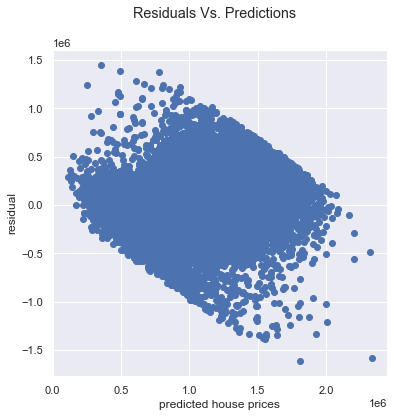

In [60]:
# plotting residuals vs predictions
model_preds = model.predict(sm.add_constant(X_cat))
resids = y - model_preds

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(model_preds, resids)

ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


From our plot, we can gather that the relationship between our target and our predictors is linear.

#### Independence

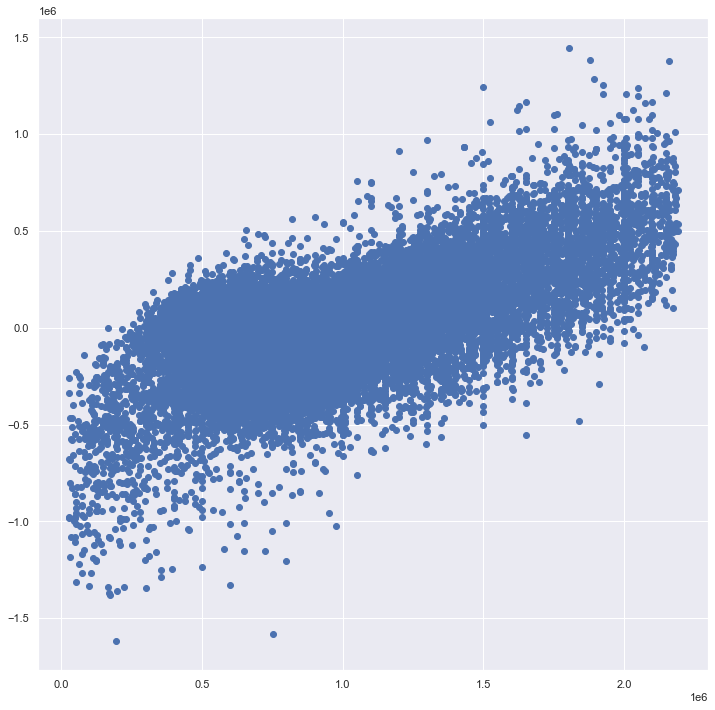

In [61]:
# plotting residuals and target value against each other to look for patterns
fig, ax = plt.subplots()

ax.scatter(y, resids);

The upwards trend in this plot suggests a very slight positive correlation in our errors.  
We can confirm by looking at the Durbin-Watson test statistic from our model.

In [62]:
durbin_watson(model.resid)

1.9885919167316604

This confirms the qualitative conclusion we drew from our scatter plot.  
Since the test statistic is below 2.0, we know there to be a very slight positive correlation in our errors.  
However, since our test statistic is so close to 2.0, we can confidently say that autocorrelation is not a problem for our regression model.

#### Normality

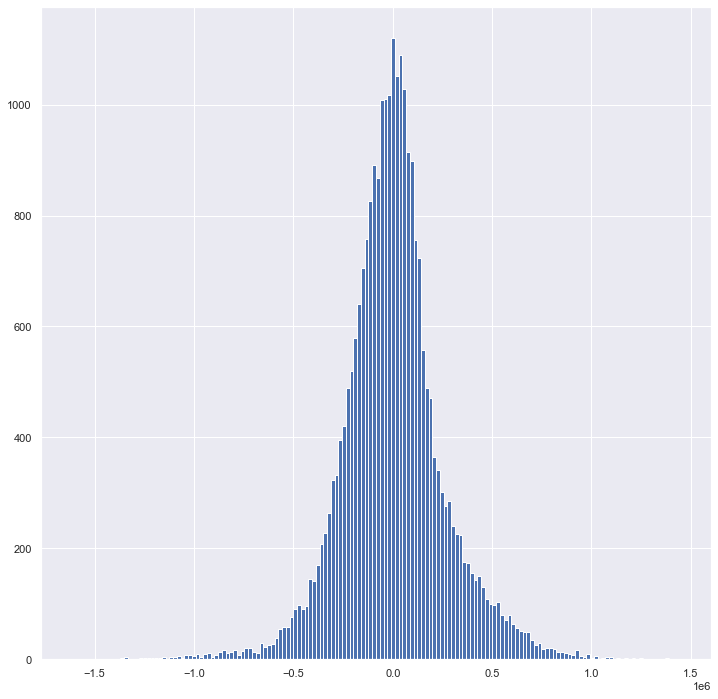

In [63]:
# Making a histogram out of our residuals
resids.hist(bins=int(np.sqrt(len(resids))));

Upon first glance at our histogram of residuals, our errors appear to be normally distributed.

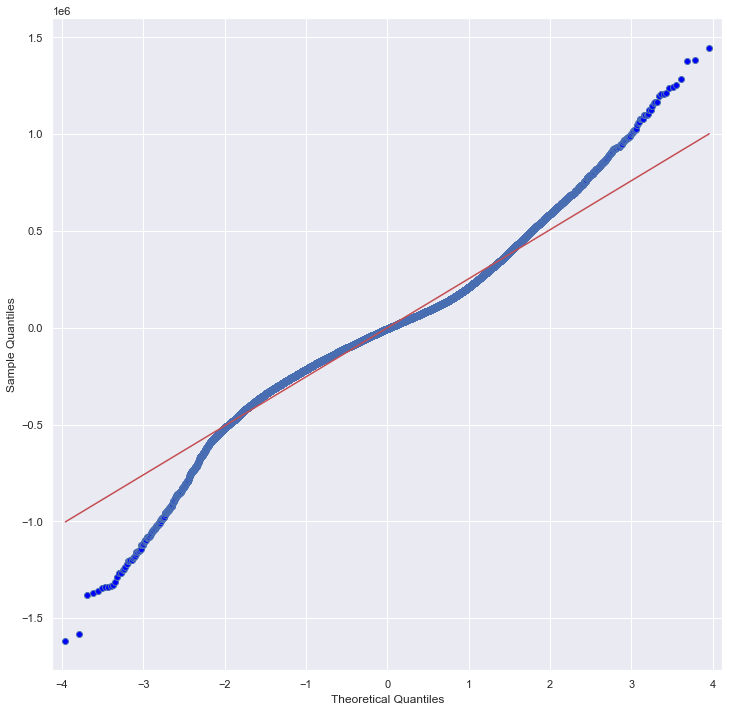

In [64]:
# Making a qqplot out of our residuals to further investigate
sm.qqplot(resids, line='r');

With normally distributed errors, our plot should follow the diagonal line closely.  
Instead, we see some fairly significant divergences at the extremes. This suggests that our errors may not follow a normal distribution. That said, it is worth noting that divergences from the diagonal line are less extreme than the last time we tested our assumptions in our previous model.

In [65]:
# For more quantitative assessment of error distribution, we turn to the Jarque-Bera test:
jarque_bera(resids)

Jarque_beraResult(statistic=7039.654966167089, pvalue=0.0)

Based on the large magnitude of our test statistic and a P-value smaller than an alpha of 0.05, we must still reject the null hypothesis that our errors are normally distributed.

Given more time, we may have to make individual histograms for each of our many variables to see their distribution, and possibly transform them in some way or use polynomial features. Unfortunately, this is outside the scope of our current project due to time constraints, and will need further investigation to address our issues with normality of errors.

#### Homoscedasticity

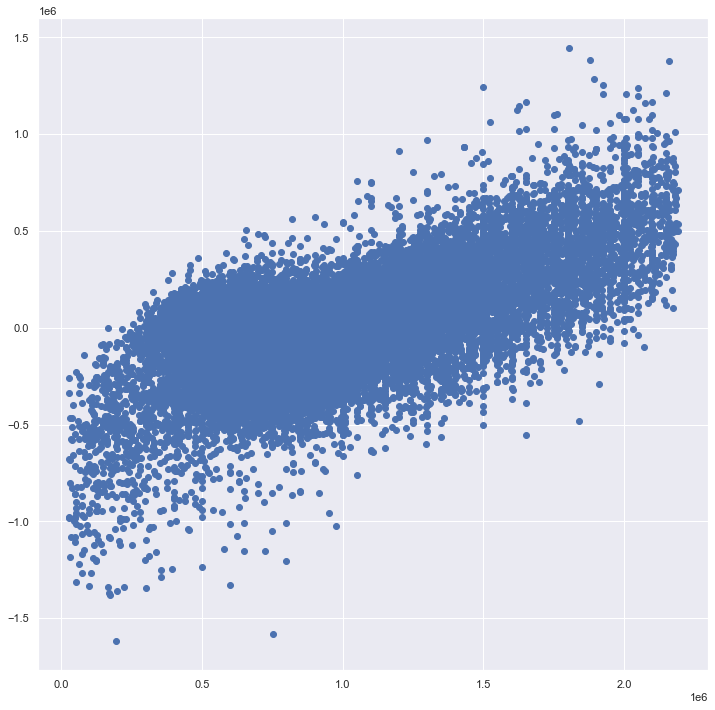

In [66]:
# We reproduce the plot from above, when we checked for independence of errors:

fig, ax = plt.subplots()

ax.scatter(y, resids);

At first glance, our errors appear to have similar variances. This is to say, the spread of our errors does not appear to vary much as our target increases. If anything, the spread may constrain slightly as our target increases, denoted by the larger presence of outliers around the smallest values of our target.

In [67]:
# For a more quantitative assessment of homoscedasticity, we employ the Goldfeld-Quant test:
sm.stats.diagnostic.het_goldfeldquandt(y,sm.add_constant(X_cat),drop=0.2)
# We chose to remove 20% of our total observations for the test, a common-practice proportion
# according to multiple online resources that were consulted.

(0.9874786620366286, 0.7351101602688859, 'increasing')

The Goldfeld-Quant test has a null hypothesis that homoscedasticity is present in our errors. Since the p-value for our test is greater than an alpha of 0.05, we fail to reject the null hypothesis and cannot gather that heteroscedasticity is a problem with our model.

In [68]:
# Turning to the Breusch-Pagan test for a second opinion on whether our data is homoscedastic:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
bp_test_result = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
lzip(names, bp_test_result)

[('Lagrange multiplier statistic', 2279.3581669918062),
 ('p-value', 0.0),
 ('f-value', 54.12149284620623),
 ('f p-value', 0.0)]

Since our p-value is smaller than our alpha of 0.05 and our test statistic is quite high for our number of predictors, we must reject the null hypothesis and conclude that there is some evidence to suggest that our errors are heteroscedastic. 

A possible solution would be to try transforming our target variable in some other way to make it more closely follow a normal distribution. Due to time constraints, this will not be possible in the present study.

#### Independence of Predictors (No Multicollinearity)

In [69]:
# Pulling out our model's condition number to tease out multicollinearity:
model.condition_number

269.39234338796416

Here we see a significant improvement over the previous iteration of our model, starting from the old baseline. Our current model's condition number is well below the generally-accepted 'danger zone' of 1000, suggesting that we eliminated any issues with multicollinearity in our model and that our predictors are sufficiently independent from one another.

#### Answering Business Question

Our initial goal was to tease out the features in our dataset that have the highest bearing on price, so as to provide our house-flipping clients information on how to turn the most profit.

#### Cheapest Cities

Upon analysis of our predictor coefficients, we found that city where a house is located has a significant bearing on the price a house will sell for. Buying lower priced homes will make return on investment on renovations higher.  We were able to ascertain which 5 cities had the highest impact on keeping house price low. In terms of our model, we found the 5 cities with the smallest relative coefficients, meaning that they increased price the *least*. 

In [70]:
cheap_cities = ['Skykomish', 'Algona', 'Federal Way', 'Enumclaw', 'Auburn']

In [71]:
df['cheap_city'] = df['city'].map(mapping_is_cheap_city)

In [72]:
df_cheap = df.loc[df['cheap_city'] == True].reset_index(drop=True)
df_cheap['mean_price'] = df['price'].mean()
df_cheap.city.value_counts()

Auburn         1500
Federal Way    1150
Enumclaw        450
Algona           50
Skykomish        16
Name: city, dtype: int64

We can plot the average prices of houses in these cities on a bar graph and compare them to the mean house price from our dataset (filtering for outliers), in order to graphically demonstrate this.

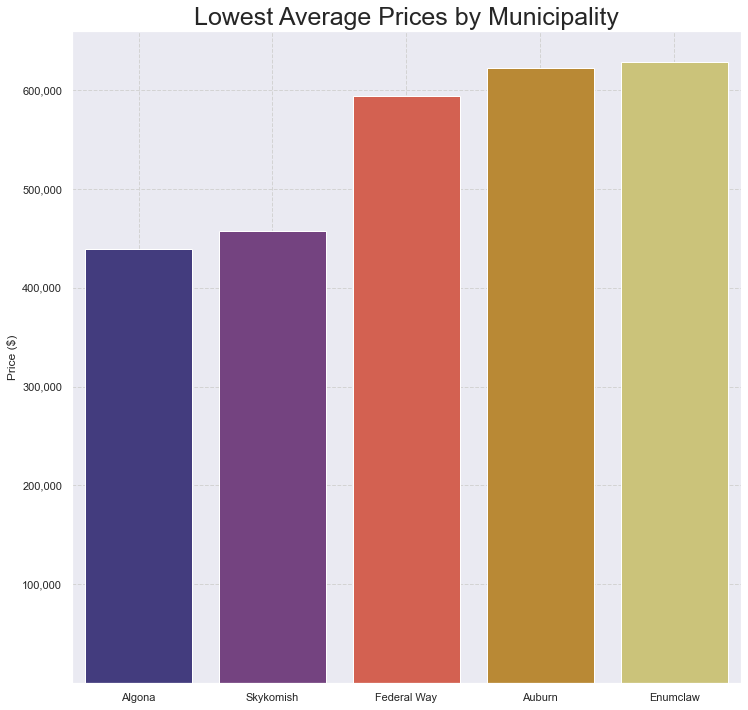

In [73]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='city', y='price', saturation=.6, palette='CMRmap',
            order=reversed(['Enumclaw', 'Auburn', 'Federal Way', 'Skykomish', 'Algona']),
            ci=None, )

ax.set_title('Lowest Average Prices by Municipality', fontsize=25)
ax.set_xlabel('')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

From our bar graph, we can see that all 5 of these cities have an average house price around or significantly under 600,000 dollars. Comparing this to the mean house price for all cities of over 900,000 dollars, we can see how much cheaper buying a house in any one of these cities would be relative to the mean.

In [74]:
df['price'].mean() # Mean house price for all cities

928346.8370652872

**Try to buy in the following cities for lowest cost:**
1. Skykomish
2. Algona
3. Federal Way
4. Enumclaw
5. Auburn

Taking another look at our model summary, we decide to look at the coefficients for our features we think would be easiest for a homeowner to add or adjust. Since garage and patio are both external structures that would be relatively easy for a homeowner to incorporate to their property, we take a look to see if their addition would significantly affect price according to our model. Below are our findings:

**Garage (x3)**

The average price of homes with garages are sold for higher than homes without garages. 

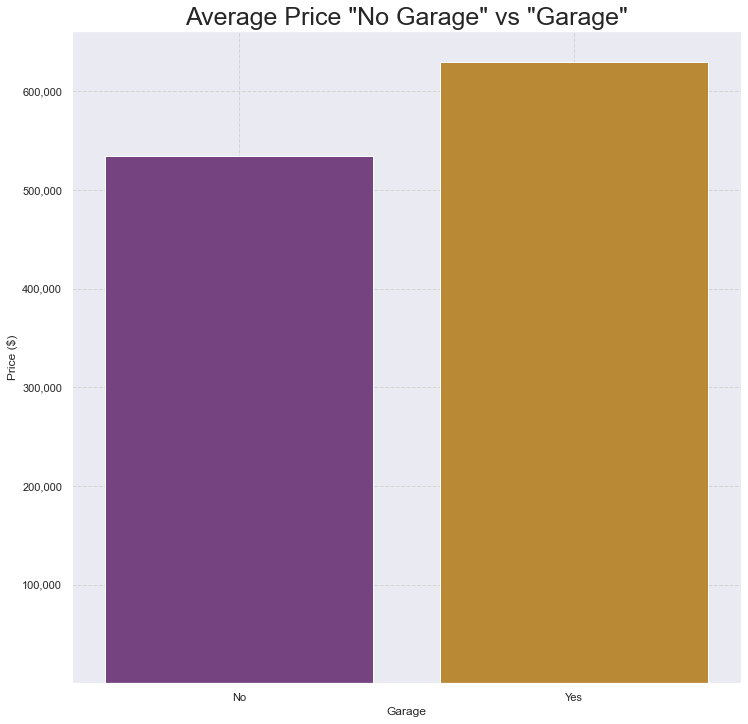

In [75]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='has_garage', y='price',
            saturation=.6, palette='CMRmap',
            order=["No", "Yes"], ci=None)

ax.set_title('Average Price \"No Garage\" vs \"Garage\"', fontsize=25)
ax.set_xlabel('Garage')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

According to our model, we are 95% confident that adding a garage will increase value by between 38,000 dollars and 54,000 dollars so to have the highest likelihood of turning a profit, if you can add a garage for under 38,000 dollars, then we believe you should. We arrive at this conclusion by interpreting our model coefficient for garage and its 95% confidence interval. These can be found in the above model summary. The coefficient for garage is approximately 46,000, which we can interpret from our model to mean that the inclusion of a garage will increase a house's price by an average of \\$46,000. Also listed on the model summary are the bounds for our 95\% confidence interval. Since the lower bound is approximately 38,000, and the upper bound is approximately 54,000, we can gather with 95\% confidence that the inclusion of a garage will increase a house's price by between \\$38,000 and \\$54,000.

**Patio (x4)**

The average price of homes with patios are sold for higher than homes without patios. 

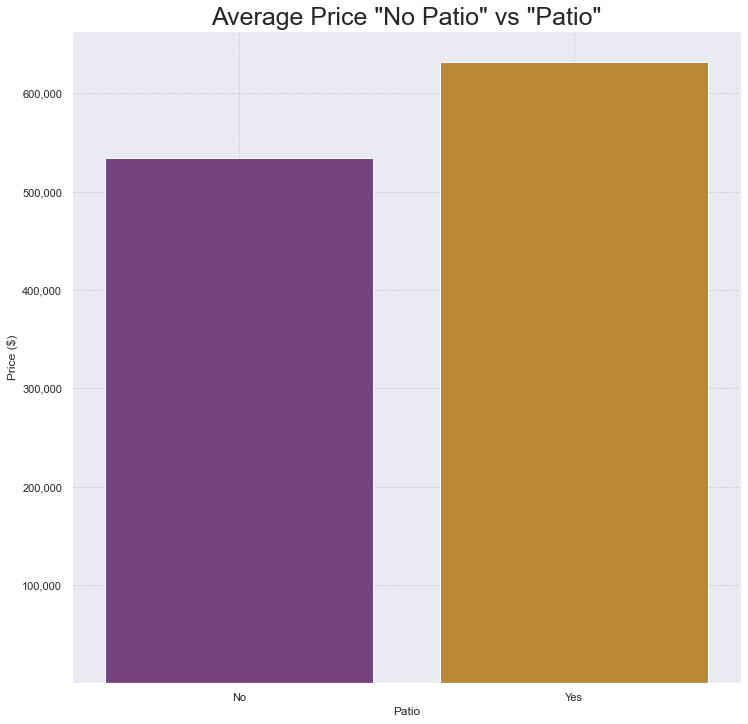

In [76]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.barplot(data=df_cheap, x='has_patio', y='price',
            saturation=.6, palette='CMRmap',
            order=["No", "Yes"], ci=None)

ax.set_title('Average Price \"No Patio\" vs \"Patio\"', fontsize=25)
ax.set_xlabel('Patio')
ax.set_ylabel('Price ($)')

ax.set_yticks([100000, 200000, 300000, 400000, 500000, 600000])
ax.set_yticklabels(['100,000', '200,000', '300,000', '400,000', '500,000', '600,000'])
ax.grid(color='lightgray', linestyle='dashed')

According to our model, we are 95% confident that adding a patio will increase value by between approximately 18,000 dollars and 33,000 dollars, so to have the highest likelihood of turning a profit, if you can add a patio for under 18,000 dollars, then we believe you should. We arrive at this conclusion by interpreting our model coefficient for patio and its 95% confidence interval. These can be found in the above model summary. The coefficient for patio is approximately 25,000, which we can interpret from our model to mean that the inclusion of a patio will increase a house's price by an average of \\$25,000. Also listed on the model summary are the bounds for our 95\% confidence interval. Since the lower bound is approximately 18,000, and the upper bound is approximately 33,000, we can gather with 95\% confidence that the inclusion of a patio will increase a house's price by between \\$18,000 and \\$33,000.

## Next steps

#### Contact contractors

You will want to contact contractors to determine the cost of adding a garage and patio to different types of houses.  Work with the contractor to get your costs under the thresholds we laid out so that you can ensure the additions will ultimately result in more profit upon sale.

#### Update the model

The data used for this analysis is current up to June 2022.  When additional home sales data is made available by the county, contact us to update our analysis to see if these conclusions are still valid and to see if there are additional conclusions and recommendations that we can make to assist your business. 

